# Prédiction des coûts Azure avec Prophet

Ce notebook a pour objectif de prévoir les coûts des services Azure sur les prochains mois à partir des données historiques disponibles.
Pour cela, nous utilisons Prophet, un modèle de série temporelle développé par Facebook, particulièrement adapté aux données présentant des tendances et une certaine saisonnalité.

L’analyse se déroule en plusieurs étapes :

Préparation des données : formatage et agrégation des coûts par date.

Entraînement du modèle Prophet sur les données passées.

Génération de prévisions pour les mois à venir.

Visualisation des tendances et des intervalles d’incertitude.

Ce travail permet d’anticiper les évolutions des dépenses cloud, et peut être utilisé pour mieux planifier les budgets ou détecter des anomalies futures.



## Mise en place d'un modèle de prédiction

### Import des données

In [ ]:

import pandas as pd

#Import des données Azure
df_azure = pd.read_csv("/Users/thomaszilliox/Desktop/Bureau - MacBook Pro de Thomas/Doc Bureau/Etudes optimisation/Etude de cas FinOps et AI/Données fictives Azure Cost Management.csv",sep=";", quotechar='"')
print(df_azure.head())
df_azure.info()




    UsageDate              ServiceName      CostUSD         Cost Currency
0  01/04/2024      Application Gateway  3728,351928  3213,558599      EUR
1  01/04/2024  Azure Analysis Services  1273,883324  1023,395045      EUR
2  01/04/2024        Azure App Service  18360,68594  16420,31301      EUR
3  01/04/2024                Azure Arc  4609,385175    4310,8096      EUR
4  01/04/2024     Azure Container Apps  28,60582862   25,6520558      EUR
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   UsageDate    49 non-null     object
 1   ServiceName  49 non-null     object
 2   CostUSD      49 non-null     object
 3   Cost         49 non-null     object
 4   Currency     49 non-null     object
dtypes: object(5)
memory usage: 2.0+ KB


In [25]:
#Import des données AWS
df_aws = pd.read_csv("/Users/thomaszilliox/Desktop/Bureau - MacBook Pro de Thomas/Doc Bureau/Etudes optimisation/Etude de cas FinOps et AI/Données fictives AWS.csv",sep=",", quotechar='"')
print(df_aws.head())
df_aws.info()

    UsageDate     Cost      ServiceName
0  2024-04-01   437.12  Amagi CLOUDPORT
1  2024-04-01   783.45          Amplify
2  2024-04-01   652.39      API Gateway
3  2024-04-01  1442.00        AppStream
4  2024-04-01   521.99           Athena
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   UsageDate    117 non-null    object 
 1   Cost         117 non-null    float64
 2   ServiceName  117 non-null    object 
dtypes: float64(1), object(2)
memory usage: 2.9+ KB


In [ ]:
# Nettoyage des données Azure
df_azure['Cost'] = df_azure['Cost'].astype(str).str.replace(',', '.').astype(float)
df_azure['UsageDate'] = pd.to_datetime(df_azure['UsageDate'],format='%d/%m/%Y')
df_azure['ServiceName'] = df_azure['ServiceName'].astype(str)

df_azure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   UsageDate    49 non-null     datetime64[ns]
 1   ServiceName  49 non-null     object        
 2   CostUSD      49 non-null     object        
 3   Cost         49 non-null     float64       
 4   Currency     49 non-null     object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 2.0+ KB


In [18]:
df_azure

,UsageDate,ServiceName,CostUSD,Cost,Currency
0,2024-04-01,Application Gateway,"3728,351928",3213.558599,EUR
1,2024-04-01,Azure Analysis Services,"1273,883324",1023.395045,EUR
2,2024-04-01,Azure App Service,"18360,68594",16420.313010,EUR
3,2024-04-01,Azure Arc,"4609,385175",4310.809600,EUR
4,2024-04-01,Azure Container Apps,"28,60582862",25.652056,EUR
5,2024-04-01,Azure DevOps,"2179,712644",2059.382780,EUR
6,2024-04-01,Azure Kubernetes Service,"309,2675592",288.719176,EUR
7,2024-04-01,Azure Managed Instance for Apache Cassandra,"1003,903837",904.140774,EUR
8,2024-04-01,Azure Policy,0,0.000000,EUR
9,2024-04-01,Azure Site Recovery,"115,9292469",104.764046,EUR


In [26]:

df_aws['Cost'] = df_aws['Cost'].astype(str).str.replace(',', '.').astype(float)
df_aws['UsageDate'] = pd.to_datetime(df_aws['UsageDate'], format='%Y-%m-%d')
df_aws['ServiceName'] = df_aws['ServiceName'].astype(str)

In [28]:
df_aws.info()

df_aws

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   UsageDate    117 non-null    datetime64[ns]
 1   Cost         117 non-null    float64       
 2   ServiceName  117 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.9+ KB


,UsageDate,Cost,ServiceName
0,2024-04-01,437.12,Amagi CLOUDPORT
1,2024-04-01,783.45,Amplify
2,2024-04-01,652.39,API Gateway
3,2024-04-01,1442.00,AppStream
4,2024-04-01,521.99,Athena
...,...,...,...
112,2024-06-01,258.55,Shield
113,2024-06-01,696.00,Step Functions
114,2024-06-01,177.88,Storage Gateway
115,2024-06-01,841.66,WorkSpaces Web


## Prédiction mensuelle des coûts 

In [8]:
from prophet import Prophet

/Users/thomaszilliox/Desktop/Bureau - MacBook Pro de Thomas/Doc Bureau/Etudes optimisation/Etude de cas FinOps et AI/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


10:38:09 - cmdstanpy - INFO - Chain [1] start processing


10:38:10 - cmdstanpy - INFO - Chain [1] done processing


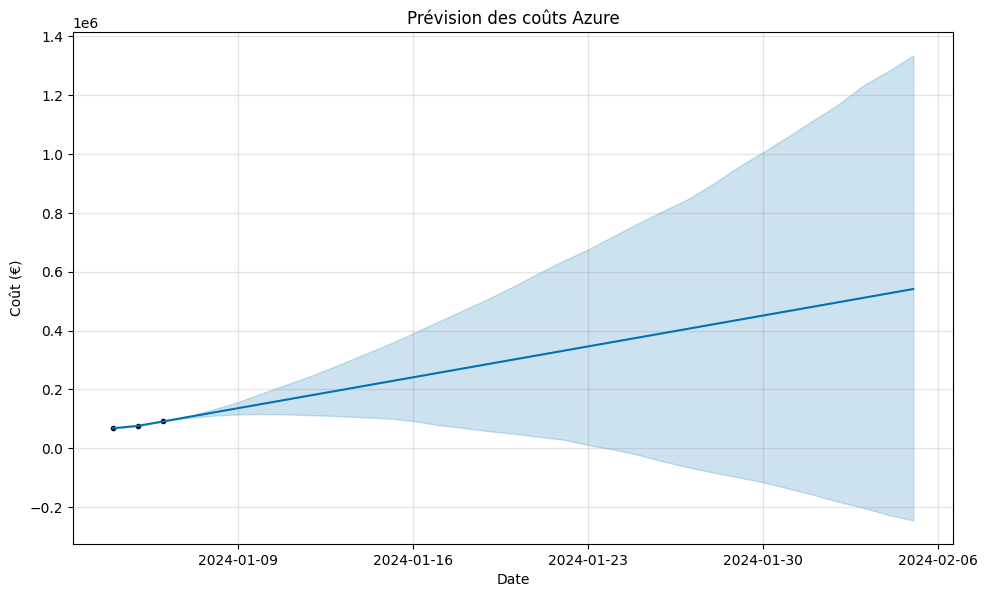

In [ ]:
# # 1. Importe le module matplotlib pour la visualisation
# import matplotlib.pyplot as plt

# # 2. Agrège les coûts par jour
# df_daily = df.groupby("UsageDate").agg({"Cost": "sum"}).reset_index()

# # 3. Renomme les colonnes pour Prophet
# df_daily.columns = ["ds", "y"]

# # 4. Initialise et entraîne le modèle Prophet
# model = Prophet()
# model.fit(df_daily)

# # 5. Crée un dataframe pour 30 jours futurs
# future = model.make_future_dataframe(periods=30)
# forecast = model.predict(future)

# # 6. Visualise les prévisions
# fig = model.plot(forecast)
# plt.title("Prévision des coûts Azure")
# plt.xlabel("Date")
# plt.ylabel("Coût (€)")
# plt.show()

16:38:12 - cmdstanpy - INFO - Chain [1] start processing
16:38:13 - cmdstanpy - INFO - Chain [1] done processing


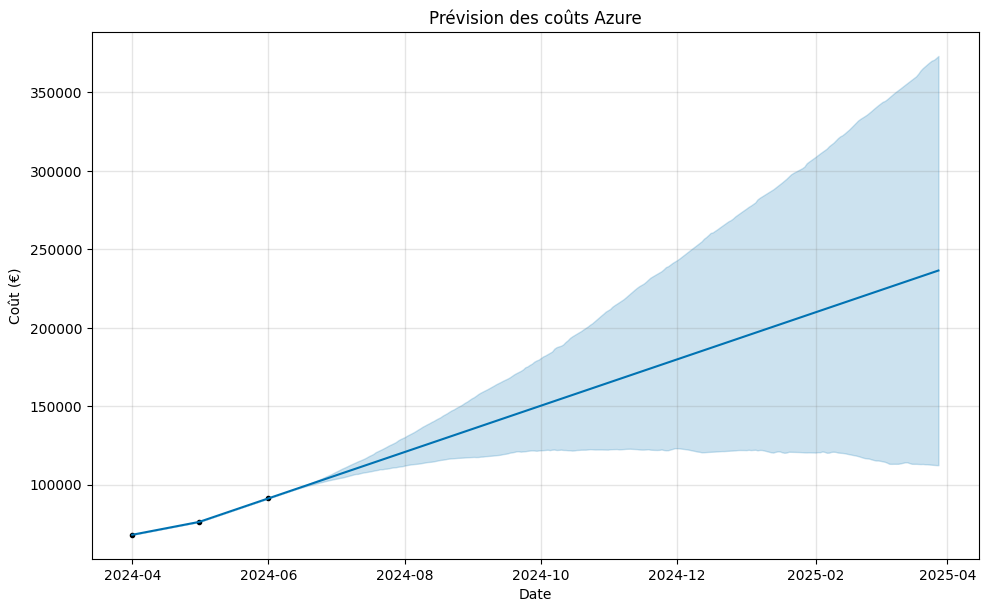

In [ ]:
# 1. Importe le module matplotlib pour la visualisation
import matplotlib.pyplot as plt

# 2. Agrège les coûts par jour
df_daily = df_azure.groupby("UsageDate").agg({"Cost": "sum"}).reset_index()

# 3. Renomme les colonnes pour Prophet
df_daily.columns = ["ds", "y"]

# 4. Initialise et entraîne le modèle Prophet
model = Prophet()
model.fit(df_daily)

# 5. Crée un dataframe pour 30 jours futurs
future = model.make_future_dataframe(periods=300)
forecast = model.predict(future)

# 6. Visualise les prévisions
fig = model.plot(forecast)
plt.title("Prévision des coûts Azure")
plt.xlabel("Date")
plt.ylabel("Coût (€)")
plt.show()

# Annoter les points réels (y) sur la courbe d'apprentissage
for x, y in zip(df_daily_2['ds'], df_daily_2['y']):
    plt.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='blue')



15:09:05 - cmdstanpy - INFO - Chain [1] start processing


15:09:06 - cmdstanpy - INFO - Chain [1] done processing


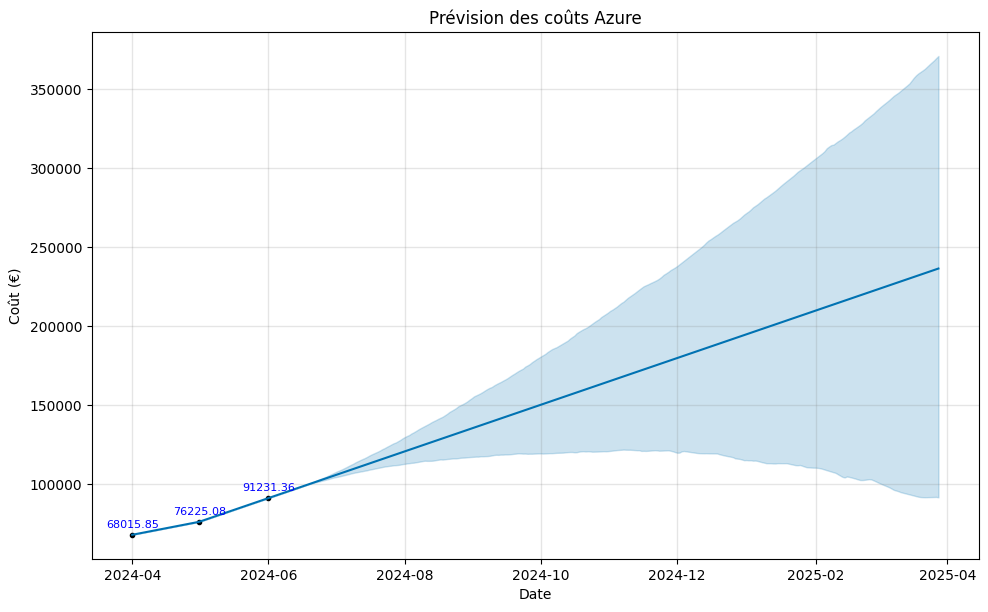

In [34]:
# 1. Importe le module matplotlib pour la visualisation
import matplotlib.pyplot as plt

# 2. Agrège les coûts par jour
df_daily = df_azure.groupby("UsageDate").agg({"Cost": "sum"}).reset_index()

# 3. Renomme les colonnes pour Prophet
df_daily.columns = ["ds", "y"]

# 4. Initialise et entraîne le modèle Prophet
model = Prophet()
model.fit(df_daily)

# 5. Crée un dataframe pour 30 jours futurs
future = model.make_future_dataframe(periods=300)
forecast = model.predict(future)

# 6. Visualise les prévisions
fig = model.plot(forecast)
plt.title("Prévision des coûts Azure")
plt.xlabel("Date")
plt.ylabel("Coût (€)")

# Annoter les points réels (y) sur la courbe d'apprentissage
for x, y in zip(df_daily['ds'], df_daily['y']):
    plt.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='blue')


plt.show()



Grâce à ce graphique généré grâce au module Prophet, nous pouvons voir que les coûts de Azure sont en augmentation au fur et à mesure des mois. Si cela continue, les coûts pourraient continuer à augmenter, il faudrait donc rapidement réaliser un audit pour observer d'où proviennent l'augmentation de ces coûts et comment les optimiser.

16:56:00 - cmdstanpy - INFO - Chain [1] start processing
16:56:00 - cmdstanpy - INFO - Chain [1] done processing


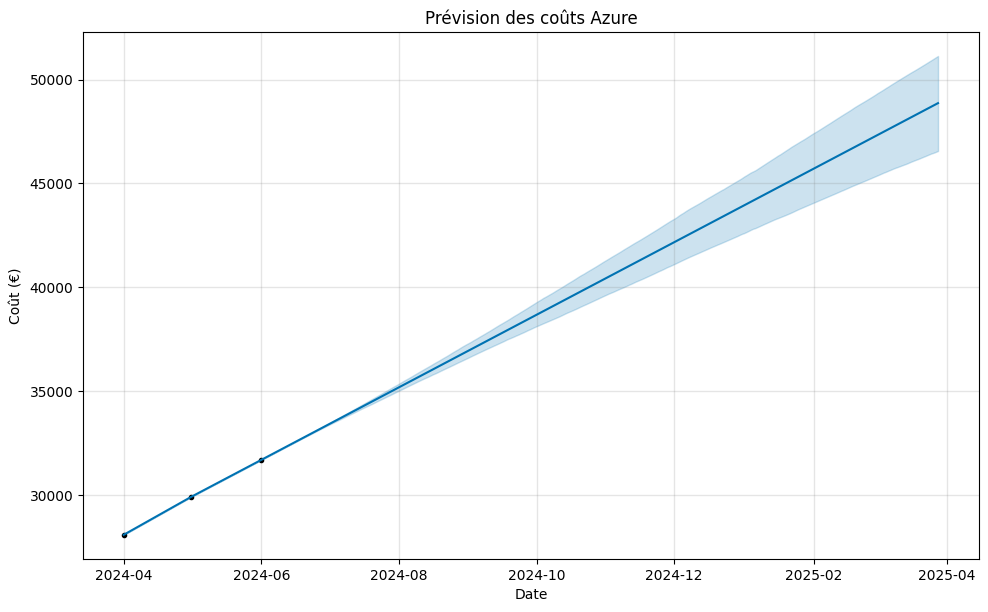

In [ ]:
# # 1. Importe le module matplotlib pour la visualisation
# import matplotlib.pyplot as plt

# # 2. Agrège les coûts par jour
# df_daily_2 = df_aws.groupby("UsageDate").agg({"Cost": "sum"}).reset_index()

# # 3. Renomme les colonnes pour Prophet
# df_daily_2.columns = ["ds", "y"]

# # 4. Initialise et entraîne le modèle Prophet
# model = Prophet()
# model.fit(df_daily_2)

# # 5. Crée un dataframe pour 30 jours futurs
# future = model.make_future_dataframe(periods=300)
# forecast = model.predict(future)

# # 6. Visualise les prévisions
# fig = model.plot(forecast)
# plt.title("Prévision des coûts AWS")
# plt.xlabel("Date")
# plt.ylabel("Coût (€)")
# plt.show()

16:58:10 - cmdstanpy - INFO - Chain [1] start processing
16:58:10 - cmdstanpy - INFO - Chain [1] done processing


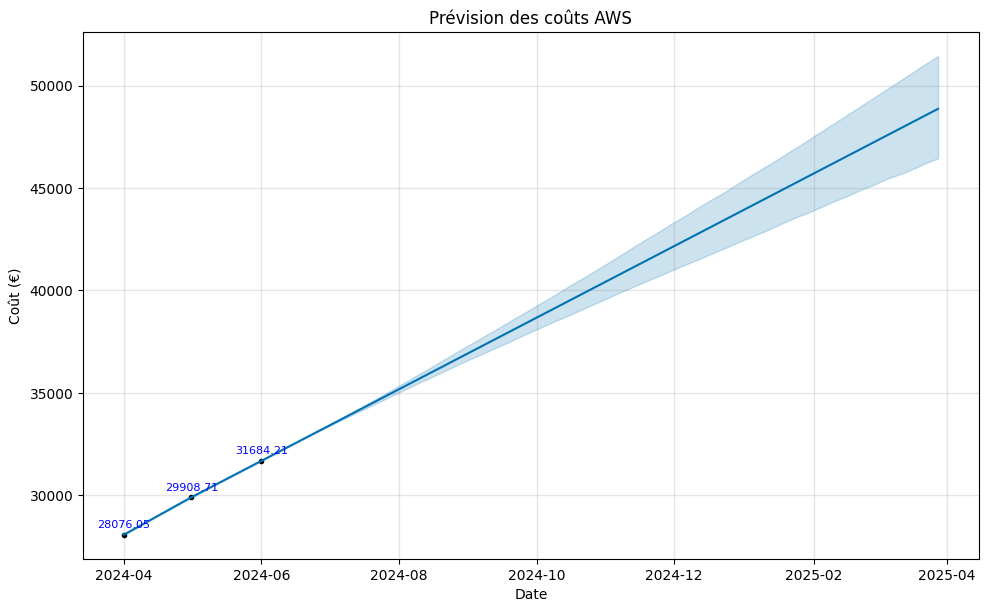

In [31]:
# 1. Importe le module matplotlib pour la visualisation
import matplotlib.pyplot as plt

# 2. Agrège les coûts par jour
df_daily_2 = df_aws.groupby("UsageDate").agg({"Cost": "sum"}).reset_index()

# 3. Renomme les colonnes pour Prophet
df_daily_2.columns = ["ds", "y"]

# 4. Initialise et entraîne le modèle Prophet
model = Prophet()
model.fit(df_daily_2)

# 5. Crée un dataframe pour 30 jours futurs
future = model.make_future_dataframe(periods=300)
forecast = model.predict(future)

# 6. Visualise les prévisions
fig = model.plot(forecast)
plt.title("Prévision des coûts AWS")
plt.xlabel("Date")
plt.ylabel("Coût (€)")

# Annoter les points réels (y) sur la courbe d'apprentissage
for x, y in zip(df_daily_2['ds'], df_daily_2['y']):
    plt.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='blue')


plt.show()

Grâce à cet autre graphique toujours généré grâce au module Prophet, nous pouvons voir que les coûts de AWS sont en augmentation au fur et à mesure des mois, tout comme pour Azure. Si cette tendance se poursuit, les coûts risquent de continuer à croître. Il serait donc pertinent de réaliser rapidement un audit afin d’identifier les sources de cette augmentation et de mettre en place des actions d’optimisation.

### Mise en place d'un agent à l'aide de Langchain

Pour simplifier l’analyse des jeux de données par l’utilisateur, nous allons mettre en place un agent IA avec Langchain. Grâce à des fonctions Python prédéfinies, il sera possible de poser des questions et d’obtenir directement les résultats souhaités par l'utilisateur de l'agent. 

In [8]:
from langchain_openai import ChatOpenAI
from langchain.agents import initialize_agent, Tool
from langchain.agents.agent_types import AgentType


In [ ]:
# Définit la fonction pour obtenir les services Azure les plus coûteux, réutilisable par l'agent

def get_top_costs(n=3, UsageDate="2025-07"):
    df = pd.read_csv("/Users/thomaszilliox/Desktop/***")
    df = df[df["UsageDate"] == UsageDate]
    df_sorted = df.sort_values(by="Cost", ascending=False).head(n)
    result = "\n".join([f"{row['Service']} : {row['Cost']}€" for _, row in df_sorted.iterrows()])
    return f"Top {n} services Azure les plus coûteux pour {UsageDate} :\n{result}"

In [ ]:
# Définis l'outil que l'agent pourra utiliser
cost_tool = Tool(
    name="TopAzureCosts",
    func=lambda x: get_top_costs(),  # pas encore dynamique
    description="Utilisé pour obtenir les services Azure les plus chers du mois"
)

api_key = "sk-proj-c*******************"  # Remplacez par votre clé API OpenAI
# Initialise l’agent avec GPT-4 ou GPT-3.5
llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo",api_key=api_key)  # ou "gpt-3.5-turbo"

agent = initialize_agent(
    tools=[cost_tool],
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

# Interroge l’agent
query = "Quels sont les services Azure les plus coûteux ce mois-ci ?"
response = agent.run(query)
print(response)
